In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/
%cp -av number-plate-detection/ ../../

/content/drive/MyDrive
'number-plate-detection/' -> '../../number-plate-detection'
'number-plate-detection/data.yaml' -> '../../number-plate-detection/data.yaml'
'number-plate-detection/TEST' -> '../../number-plate-detection/TEST'
'number-plate-detection/TEST/TEST.jpeg' -> '../../number-plate-detection/TEST/TEST.jpeg'
'number-plate-detection/TEST/TEST.mp4' -> '../../number-plate-detection/TEST/TEST.mp4'
'number-plate-detection/images' -> '../../number-plate-detection/images'
'number-plate-detection/images/N128.xml' -> '../../number-plate-detection/images/N128.xml'
'number-plate-detection/images/N121.xml' -> '../../number-plate-detection/images/N121.xml'
'number-plate-detection/images/N129.xml' -> '../../number-plate-detection/images/N129.xml'
'number-plate-detection/images/N124.xml' -> '../../number-plate-detection/images/N124.xml'
'number-plate-detection/images/N100.jpeg' -> '../../number-plate-detection/images/N100.jpeg'
'number-plate-detection/images/N118.xml' -> '../../number-plate

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
IMAGE_SIZE = 224

In [ ]:
basepath = "/content/number-plate-detection/images"
import os
import shutil
images = '/content/images/'
annotations = '/content/annotations/'
os.makedirs(images, exist_ok=True)
os.makedirs(annotations, exist_ok=True)

# Define a list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Create a list of image filenames in 'data_path'

xmls_list = [filename for filename in os.listdir(basepath) if os.path.splitext(filename)[-1] in ['.xml']]
print(len(xmls_list))
imgs_list = [filename for filename in os.listdir(basepath) if os.path.splitext(filename)[-1] in image_extensions and (os.path.splitext(filename)[0]) + '.xml' in xmls_list]
print(len(imgs_list))

cnt=0
xmls_list.sort()
imgs_list.sort()
for i in range(len(xmls_list)):
  if os.path.splitext(xmls_list[i])[0] == os.path.splitext(imgs_list[i])[0]:
    cnt+=1

print(cnt)


for filename in imgs_list:
    shutil.move(os.path.join(basepath, filename), os.path.join(images, filename))
for filename in xmls_list:
    shutil.move(os.path.join(basepath, filename), os.path.join(annotations, filename))



225
225
225


In [ ]:
img_dir = "/content/images" # Enter Directory of all images
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))


In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]


In [ ]:
path = '/content/annotations/'
text_files = ['/content/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [ ]:
resizeannotation("/content/annotations/N1.xml")

[162, 150, 127, 133]

In [ ]:
y[0]

[162, 150, 127, 133]

In [ ]:
np.array(X).shape

(225, 224, 224, 3)

In [ ]:
np.array(y).shape

(225, 4)

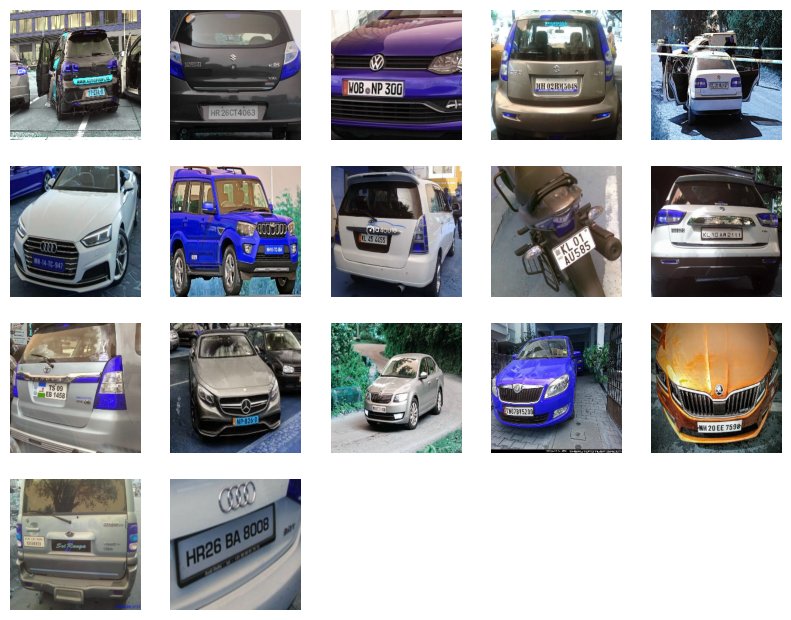

In [ ]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

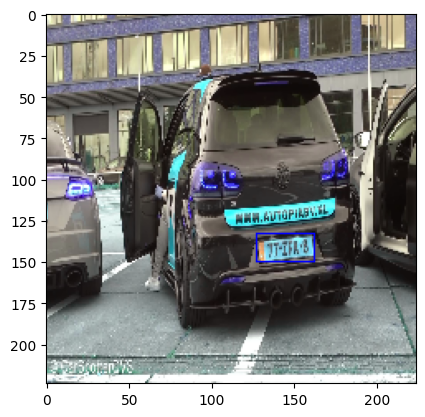

In [ ]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


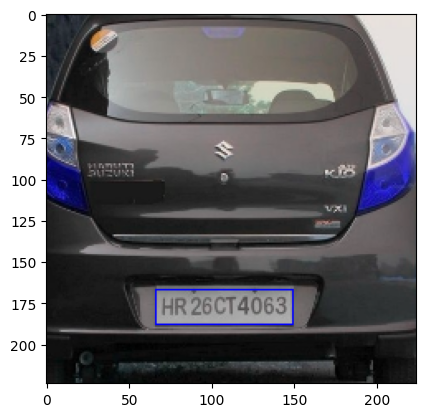

In [ ]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


In [ ]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [ ]:
#Renormalisation
X = X / 255
y = y / 255

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
from keras.models import Sequential
import keras
from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [ ]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:

model = keras.models.load_model('/content/drive/MyDrive/VGGModel/my_model_vgg.h5')

In [ ]:
# csv_logger = CSVLogger('/content/drive/MyDrive/training.log')
#train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1,
#steps_per_epoch = len(X_train)//32,callbacks=[csv_logger])

In [ ]:
# model.save('/content/drive/MyDrive/my_model_vgg.h5', overwrite=True)

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 75.56%


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
plot_scores(model)

TypeError: 'History' object is not subscriptable

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(25))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


23/25 [==========================>...] - ETA: 2s - loss: 0.0063 - accuracy: 0.7556

25/25 [==============================] - 29s 1s/step - loss: 0.0063 - accuracy: 0.7556
Test results 
 Loss: 0.006341043394058943 
 Accuracy 0.7555555701255798


In [ ]:
import time
res=0
cnt=0
totalTime=0

start=time.time()
y_cnn = model.predict(X_test)
end=time.time()

totalTime = (end-start)/len(X_test)
print(totalTime)

2/2 [==============================] - 34s 6s/step
0.7618131902482774


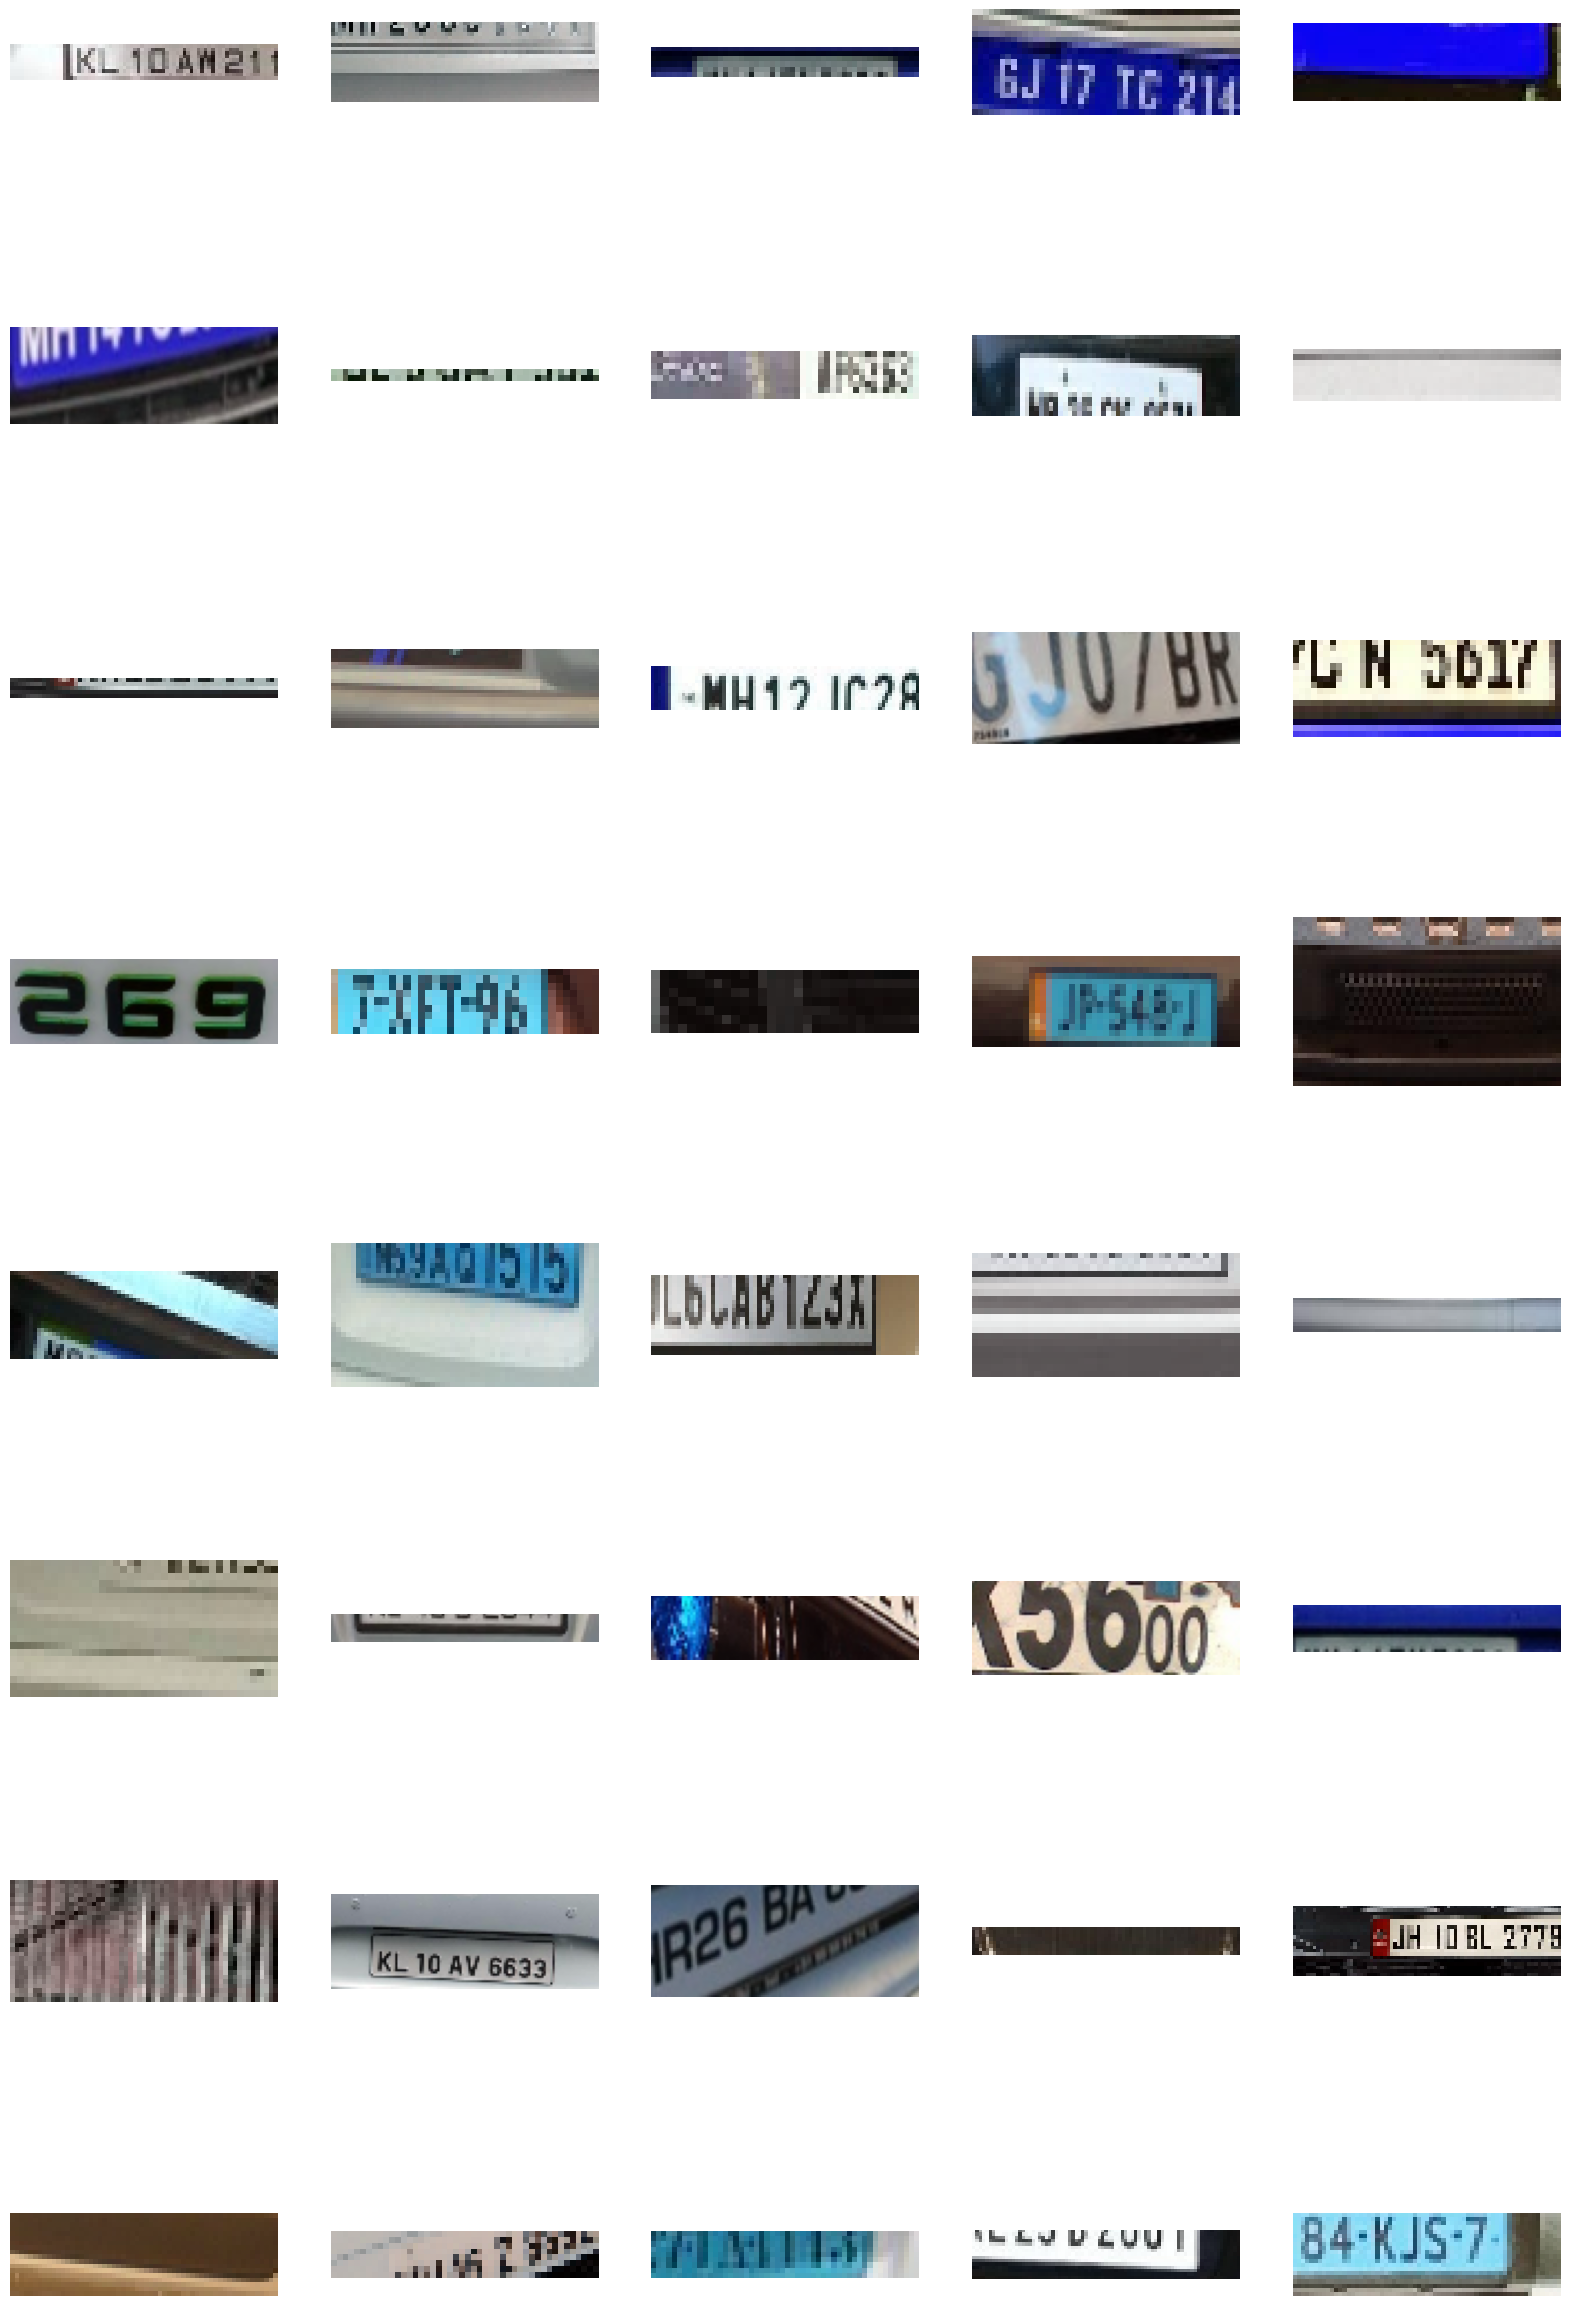

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,40) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    # image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    y1, y2 = int(min(ny[1], ny[3])), int(max(ny[1], ny[3]))
    x1, x2 = int(min(ny[0], ny[2])), int(max(ny[0], ny[2]))
    image = X_test[i][y1:y2, x1:x2]
    plt.imshow(image)

